In [13]:
!pip install category_encoders
!pip install texthero

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 238 kB 9.9 MB/s 
     |████████████████████████████████| 1.4 MB 7.6 MB/s 
     |████████████████████████████████| 10.4 MB 5.8 MB/s 
     |████████████████████████████████| 366 kB 3.4 MB/s 
     |████████████████████████████████| 24.2 MB 5.4 MB/s 
     |████████████████████████████████| 6.8 MB 11.1 MB/s 
     |████████████████████████████████| 82 kB 2.4 MB/s 
     |████████████████████████████████| 723 kB 15.3 MB/s 
     |████████████████████████████████| 293 kB 2.6 MB/s 
     |████████████████████████████████| 284 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 9.9 MB/s 
     |████████████████████████████████| 117 kB 17.9 MB/s 
  Cr

In [2]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 66.3 MB 5.8 MB/s 
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import pathlib
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import texthero as hero
from texthero import preprocessing

from sklearn import metrics
from sklearn.model_selection import GroupKFold, KFold

import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.decomposition import PCA
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import model_selection

from catboost import CatBoost
from catboost import Pool

In [2]:
DATA_DIR = pathlib.Path('/home/knikaido/work/atma8/data/')
OUTPUT_DIR = './sub19/'
train_csv_path = DATA_DIR / 'train.csv'
test_csv_path = DATA_DIR / 'test.csv'

In [3]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
whole_df = pd.concat([train_df, test_df], ignore_index=True)

In [4]:
train_column = train_df.columns

In [5]:
X_column = []
for s in train_column:
    if not'Sales' in s:
        X_column.append(s)

In [6]:
train_df_drop = train_df[X_column]

In [7]:
# User_Scoreの変換
def make_user_score(df):
    d = df['User_Score'].copy()
    d[d == 'tbd'] = 'nan'
    df.loc[:,'User_Score'] = d
    
    return df

In [8]:
train_df_drop = make_user_score(train_df_drop)
test_df = make_user_score(test_df)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [9]:
def add_pub_dev_info(df1, df2, tgt, col, func='count'):
    whole_df = pd.concat([df1, df2], ignore_index=True)
    plat_pivot = whole_df.pivot_table(index=tgt, columns=col, values='Name', aggfunc=func).reset_index()
    plat_pivot.fillna(0, inplace=True)

    n_ = 5
    pca = PCA(n_components=n_)
    plat_pca = pca.fit_transform(plat_pivot.iloc[:, 1:].values) 
    cols = [tgt[:2] +  '_' + col+'_pca_'+str(i) for i in range(n_)]
    plat_pca_df = pd.DataFrame(plat_pca, index=plat_pivot.iloc[:,0], columns=cols)
    whole_df = pd.merge(whole_df, plat_pca_df, on=tgt, how='left')

    df1 = whole_df.iloc[:len(df1), :]
    df2 = whole_df.iloc[len(df1):, :]
    return df1, df2

In [10]:
train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'Platform')
train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'Genre')
train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'Rating')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'Critic_Score')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'Critic_Count')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'User_Score')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'User_Count')

train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'Platform')
train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'Genre')
train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'Rating')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'Critic_Score')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'Critic_Count')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'User_Score')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'User_Count')

train_df_drop

,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,...,De_Genre_pca_0,De_Genre_pca_1,De_Genre_pca_2,De_Genre_pca_3,De_Genre_pca_4,De_Rating_pca_0,De_Rating_pca_1,De_Rating_pca_2,De_Rating_pca_3,De_Rating_pca_4
0,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,74.0,17.0,7.9,22.0,Traveller's Tales,...,11.001662,60.676705,-14.921881,1.765402,-6.857721,21.425117,10.486456,52.322374,-8.557706,-0.083993
1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,78.0,22.0,6.6,28.0,Traveller's Tales,...,11.001662,60.676705,-14.921881,1.765402,-6.857721,21.425117,10.486456,52.322374,-8.557706,-0.083993
2,LEGO Batman: The Videogame,PSP,NaN,Action,Warner Bros. Interactive Entertainment,73.0,5.0,7.4,10.0,Traveller's Tales,...,11.001662,60.676705,-14.921881,1.765402,-6.857721,21.425117,10.486456,52.322374,-8.557706,-0.083993
3,Combat,2600,NaN,Action,Atari,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,Warner Bros. Interactive Entertainment,76.0,8.0,7.8,13.0,Traveller's Tales,...,11.001662,60.676705,-14.921881,1.765402,-6.857721,21.425117,10.486456,52.322374,-8.557706,-0.083993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,Stellaris,PC,2016.0,Strategy,Paradox Interactive,78.0,57.0,8,569.0,Paradox Development Studio,...,-1.257383,-1.275148,-0.316958,-0.340787,-0.374459,-2.262654,-0.232654,1.623968,-0.834035,-0.005679
8355,Total War Attila: Tyrants & Kings,PC,2016.0,Strategy,Koch Media,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8356,Brothers Conflict: Precious Baby,PSV,2017.0,Action,Idea Factory,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8357,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,2017.0,Role-Playing,Sega,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# cols = 'Name_0'
# fig, ax = plt.subplots(figsize = (16, 6))

# sns.distplot(train_df_drop['Pu_Critic_Score_pca_0'].values, 
#              hist=True, rug=True, label='train',kde_kws=dict(linewidth=4))
# sns.distplot(test_df['Pu_Critic_Score_pca_0'].values, 
#              hist=True, rug=True, label='test', kde_kws=dict(linewidth=4))
# ax.set_title(f'Distribution for {cols}', fontsize=16)
# sns.despine(left=True, bottom=True)
# plt.legend()
# plt.show()

In [12]:
# train_df_drop

In [13]:
# plt.plot(train_df_drop['plat_pca_1'])
# plt.plot(train_df_drop['plat_pca_0'])
# plt.plot(train_df_drop['Publisher'])

In [14]:
# plt.plot(train_df_drop['Publisher'])

In [15]:
# train_df_drop

In [16]:
# Ratingの変換

In [17]:
def encode_label(train, test):
    cate_col = ['Rating', 'Platform', 'Genre']
    oe = ce.OrdinalEncoder(cols=cate_col, drop_invariant=True, handle_missing='return_nan')
    train.loc[:,cate_col] = oe.fit_transform(train[cate_col])
    test.loc[:,cate_col] = oe.transform(test[cate_col])
    return train, test

In [18]:
train_df_drop, test_df = encode_label(train_df_drop, test_df)

/home/user/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [19]:
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                  ]

In [20]:
def translate_name(df1, df2):
    df = pd.concat([df1, df2])
    tif_vec = hero.tfidf(hero.clean(df['Name'], pipeline=custom_pipeline))
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Name'], pipeline=custom_pipeline)))
    tif_vec_l = []
    for i in range(len(tif_vec)):
        tif_vec_l.append(tif_vec.values[i])
    tif_vec_np = np.array(tif_vec_l)

#     km = KMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
#     y_km = km.fit_predict(tif_vec_np)
#     df['kmeans_name'] = y_km
    
    pca = PCA(n_components=30)
    tif_vec_pca = pca.fit_transform(tif_vec_np) 
#     tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
#     tif_vec_pca = tsne.fit_transform(tif_vec_np)
    
    for i in range(tif_vec_pca.shape[1]):
        c_ = 'Name_' + str(i)
        df[c_] = tif_vec_pca[:, i]
    df1 = df.iloc[:len(df1), :]
    df2 = df.iloc[len(df1):, :]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Developer'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Developer_0'] = n_pca_np[:, 0]
#     df['Developer_1'] = n_pca_np[:, 1]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Publisher'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Publisher_0'] = n_pca_np[:, 0]
#     df['Publisher_1'] = n_pca_np[:, 1]
    
    return df1, df2

In [21]:
train_df_drop, test_df = translate_name(train_df_drop, test_df)


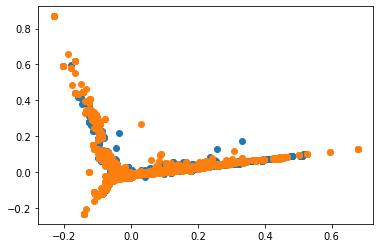

In [22]:
plt.scatter(train_df_drop['Name_0'].values, train_df_drop['Name_1'].values)
plt.scatter(test_df['Name_0'].values, test_df['Name_1'].values)

In [23]:
def translate_name_wav2vec(df1, df2):
    df = pd.concat([df1, df2])
    C_Name = hero.clean(df['Name'], pipeline=custom_pipeline)
    sentences = []
    for sentence in C_Name:
        data = sentence.split()
        sentences.append(data)
    model = word2vec.Word2Vec(sentences,
                              size=200,
                              min_count=1,
                              window=5,
                              iter=20,
                              sg = 0)
    w_vec = []
    for sentence in C_Name:
        data = sentence.split()
        tmp = np.zeros(200)
        for d in data:
            tmp += model[d]
        w_vec.append(tmp)
    w_vec = np.array(w_vec)
    
    pca = PCA(n_components=30)
    w_vec_pca = pca.fit_transform(w_vec) 
#     tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
#     w_vec_pca = tsne.fit_transform(w_vec_pca)
    for i in range(w_vec_pca.shape[1]):
        c_ = 'W_Name_' + str(i)
        df[c_] = w_vec_pca[:, i]
        
        
        
#     pca = PCA(n_components=10)
#     w_vec_pca = pca.fit_transform(w_vec)
    
#     df['Name_0'] = w_vec_pca[:, 0]
#     df['Name_1'] = w_vec_pca[:, 1]
#     df['Name_2'] = w_vec_pca[:, 2]
#     df['Name_3'] = w_vec_pca[:, 3]
#     df['Name_4'] = w_vec_pca[:, 4]
#     df['Name_5'] = w_vec_pca[:, 5]
#     df['Name_6'] = w_vec_pca[:, 6]
#     df['Name_7'] = w_vec_pca[:, 7]
#     df['Name_8'] = w_vec_pca[:, 8]
#     df['Name_9'] = w_vec_pca[:, 9]
    df1 = df.iloc[:len(df1), :]
    df2 = df.iloc[len(df1):, :]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Developer'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Developer_0'] = n_pca_np[:, 0]
#     df['Developer_1'] = n_pca_np[:, 1]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Publisher'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Publisher_0'] = n_pca_np[:, 0]
#     df['Publisher_1'] = n_pca_np[:, 1]
    
    return df1, df2

In [24]:
train_df_drop, test_df = translate_name_wav2vec(train_df_drop, test_df)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [25]:
drop_c = ['Name', 'Publisher', 'Developer']
train_df_drop.drop(drop_c, axis=1, inplace=True)
test_df.drop(drop_c, axis=1, inplace=True)
train_df_drop

,Platform,Year_of_Release,Genre,Critic_Score,Critic_Count,User_Score,User_Count,Rating,Pu_Platform_pca_0,Pu_Platform_pca_1,...,W_Name_20,W_Name_21,W_Name_22,W_Name_23,W_Name_24,W_Name_25,W_Name_26,W_Name_27,W_Name_28,W_Name_29
0,1.0,NaN,1.0,74.0,17.0,7.9,22.0,1.0,48.983372,-21.987509,...,0.072894,0.607196,-0.594438,-0.495829,0.238287,0.533678,0.288494,-0.499573,-0.218411,-0.119298
1,1.0,NaN,1.0,78.0,22.0,6.6,28.0,1.0,19.845629,2.303901,...,0.197929,0.260995,-0.129954,-0.338780,0.209421,-0.189592,0.252302,-0.365215,-0.031793,-0.747223
2,2.0,NaN,1.0,73.0,5.0,7.4,10.0,1.0,48.983372,-21.987509,...,0.072894,0.607196,-0.594438,-0.495829,0.238287,0.533678,0.288494,-0.499573,-0.218411,-0.119298
3,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,87.992511,-5.615959,...,0.008696,0.279305,-0.049246,0.009938,-0.086281,-0.070374,-0.059986,0.022426,-0.125396,-0.045203
4,1.0,NaN,1.0,76.0,8.0,7.8,13.0,1.0,48.983372,-21.987509,...,1.934382,0.969398,0.653263,-2.222314,1.601243,-1.185167,-0.582930,-0.814284,-0.042366,-1.324341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,9.0,2016.0,12.0,78.0,57.0,8,569.0,NaN,-3.029079,-0.973596,...,0.191105,0.130030,0.018399,-0.049067,-0.047802,-0.018134,-0.005868,-0.027487,0.014672,0.042405
8355,9.0,2016.0,12.0,NaN,NaN,NaN,NaN,NaN,-3.591453,-0.481136,...,0.163966,0.276366,-0.426212,-0.342887,-0.123936,-0.085182,0.325640,-0.059686,-0.909380,-0.265610
8356,14.0,2017.0,1.0,NaN,NaN,NaN,NaN,NaN,23.709706,23.341467,...,-0.117977,0.086958,-0.093166,0.133444,-0.065721,-0.309863,0.031151,-0.157915,-0.049271,-0.054904
8357,30.0,2017.0,8.0,NaN,NaN,NaN,NaN,NaN,146.907780,-5.172567,...,-0.240322,0.721113,-0.011957,0.880095,-0.636215,-0.137133,0.033497,-0.330918,0.377565,0.148428


In [26]:
train_df_drop = train_df_drop.astype('float64')
test_df = test_df.astype('float64')

In [27]:
X = train_df_drop
y = train_df['Global_Sales'].astype('float64')
groups = train_df['Publisher']

In [28]:
def create_folds(data, target_col):
    num_bins = np.int(1 + np.log2(len(data)))
    bins = pd.cut(
        data[target_col],
        bins=num_bins,
        labels=False
    )
    kf = model_selection.StratifiedKFold(n_splits=10)
    fold_ids = list(kf.split(X=data, y=bins.values))
    return fold_ids

fold_ids = create_folds(train_df, "Global_Sales")

/home/user/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



In [33]:

# kfoldの分割数
k = 10
# kf = KFold(n_splits=k, shuffle=True, random_state=0)
# kf = GroupKFold(n_splits=k)

lgbm_params = {'objective': 'regression',
              "metric":"rmse",
               'max_dapth': 8,
              "learning_rate": 0.01,
               'colsample_bytree': 0.8}

cat_params = {
    # 損失関数に RMSE を使う
    'loss_function': 'RMSE',
    'num_boost_round': 10000,
    "learning_rate": 0.01,
    'use_best_model': True,
    'early_stopping_rounds': 1000,
}

rmsle_train_list = []
rmsle_eval_list = []

pred_test_np = np.zeros([k, len(test_df)])
oof_pred = np.zeros_like(y, dtype=np.float)

# kfoldで分割
for i, (train_index, test_index) in enumerate(fold_ids):

    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)
    

    # データセットを生成する
    train_pool = Pool(X_train, label=y_train)
    eval_pool = Pool(X_test, label=y_test)
#     lgb_train = lgb.Dataset(X_train, y_train)
#     lgb_eval = lgb.Dataset(X_test, y_test)

    # 学習
    model = CatBoost(cat_params)
    model.fit(train_pool, eval_set=[train_pool, eval_pool], verbose_eval=200, early_stopping_rounds=1000)
#     model = lgb.train(lgbm_params,
#                         lgb_train,
#                         valid_sets=[lgb_eval, lgb_train],
#                         num_boost_round=10000,
#                         early_stopping_rounds=1000,
#                         verbose_eval=200)

    predict_train = model.predict(train_pool)
    predict_eval = model.predict(eval_pool)

#     predict_train = model.predict(X_train, num_iteration=model.best_iteration)
#     predict_eval = model.predict(X_test, num_iteration=model.best_iteration)
    oof_pred[test_index] = predict_eval
    
    rmsle_train = np.sqrt(mean_squared_error(y_train, predict_train))
    rmsle_eval = np.sqrt(mean_squared_error(y_test, predict_eval))
    print(f'RMSLE_train: {rmsle_train}, RMSLE_eval: {rmsle_eval}')
    rmsle_train_list.append(rmsle_train)
    rmsle_eval_list.append(rmsle_eval)
    
    pred_test_np[i] = model.predict(test_df)
    
print(f'RMSLE_train_mean: {np.mean(rmsle_train_list)}, RMSLE_eval_mean: {np.mean(rmsle_eval_list)}')

    # predict_probaが0.5以上なら1とする
#     predict = [0 if i < 0.5 else 1 for i in predict_proba]

#     auc, precision, recall = get_evaluate(y_test, predict)

#     print('AUC:{}, precision:{}, recall:{}'.format(auc, precision, recall))

#     auc_list.append(auc)
#     precision_list.append(precision)
#     recall_list.append(recall)

# # kfoldの平均値を取得
# print('Kfold平均 AUC:{}, precision:{}, recall:{}'.format(np.mean(auc_list), 
#                                                          np.mean(precision_list), 
#                                                          np.mean(recall_list)))

0:	learn: 1.3810589	test: 1.3810589	test1: 1.4631238	best: 1.4631238 (0)	total: 3.39ms	remaining: 33.9s
200:	learn: 1.0191570	test: 1.0191570	test1: 1.2378087	best: 1.2378087 (200)	total: 660ms	remaining: 32.2s
400:	learn: 0.9360231	test: 0.9360231	test1: 1.1759861	best: 1.1663707 (325)	total: 1.31s	remaining: 31.5s
600:	learn: 0.8908528	test: 0.8908528	test1: 1.2614827	best: 1.1663707 (325)	total: 1.99s	remaining: 31.1s
800:	learn: 0.8557397	test: 0.8557397	test1: 1.3386276	best: 1.1663707 (325)	total: 2.67s	remaining: 30.7s
1000:	learn: 0.8238427	test: 0.8238427	test1: 1.3983748	best: 1.1663707 (325)	total: 3.36s	remaining: 30.2s
1200:	learn: 0.7954801	test: 0.7954801	test1: 1.4423119	best: 1.1663707 (325)	total: 4.04s	remaining: 29.6s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 1.166370657
bestIteration = 325

Shrink model to first 326 iterations.
RMSLE_train: 0.9598620451672423, RMSLE_eval: 1.1663706614092284
0:	learn: 1.3864247	test: 1.3864247	test1: 1.4043

In [35]:
print(np.sqrt(mean_squared_error(np.log1p(y), oof_pred)))

0.9125708127966339


In [36]:
oof_df = pd.DataFrame(oof_pred, columns=['Global_Sales'])
oof_df.to_csv(OUTPUT_DIR + "oof19.csv", index = False)

In [37]:
pred_test_mean = np.mean(pred_test_np, axis=0)
pred_test_exp = np.expm1(pred_test_mean)

In [ ]:
sub = pd.read_csv(DATA_DIR / 'atmaCup8_sample-submission.csv')
sub['Global_Sales'] = pred_test_exp
sub.to_csv(OUTPUT_DIR + "sub19.csv", index = False)

In [29]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    model = models
#     for i, model in enumerate(models):
    _df = pd.DataFrame()
    _df['feature_importance'] = model.feature_importance(importance_type='gain')
    _df['column'] = feat_train_df.columns
    _df['fold'] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

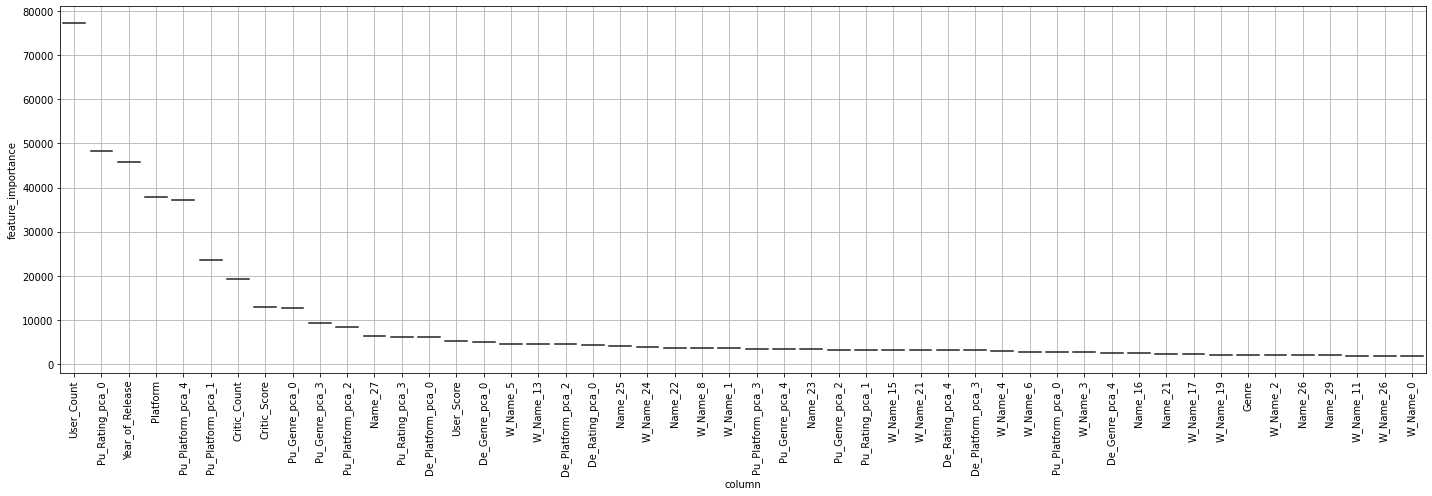

In [30]:
fig, ax = visualize_importance(model, X)


In [31]:
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=train_df_drop.columns, columns=['importance'])
importance.sort_values(['importance'])

,importance
Name_2,480.053053
De_Genre_pca_1,487.682237
Pu_Rating_pca_4,492.458571
W_Name_16,569.135340
Pu_Genre_pca_1,570.898948
...,...
Pu_Platform_pca_4,37240.968674
Platform,37902.404673
Year_of_Release,45852.956616
Pu_Rating_pca_0,48275.338334


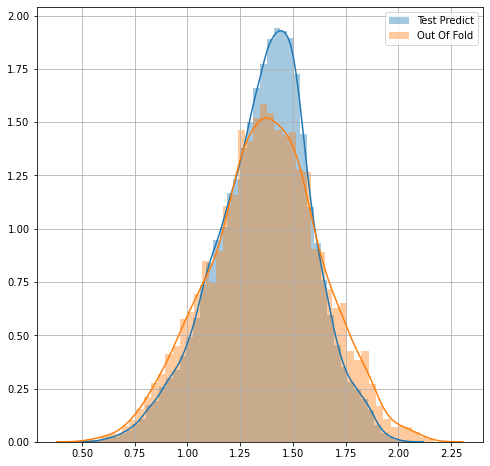

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(pred_test_np), label='Test Predict')
sns.distplot(np.log1p(oof_pred), label='Out Of Fold')
ax.legend()
ax.grid()

In [37]:
train_df_drop.corr().style.background_gradient(axis=None)